<div style="color:#8b1538; font-size:35px;">Graphic representation using matplotlib and seaborn</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

<br>

<div style="font-size: 32px; font-style: bold;">SFS shape verification</div>

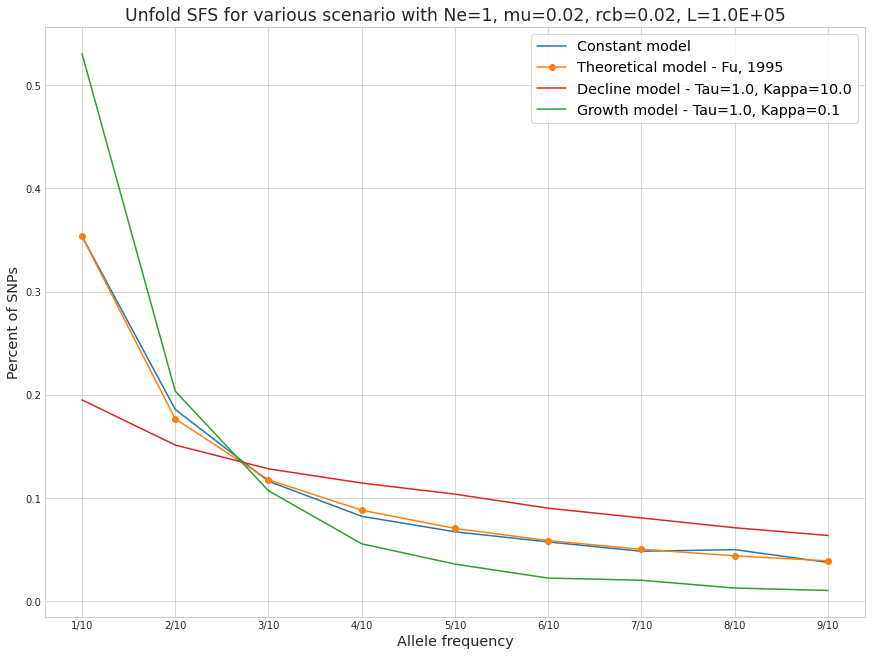

<Figure size 432x288 with 0 Axes>

In [2]:
data = f.load_sfs(function=sei.generate_set_sfs, generate=False)
plot.plot_sfs(data)

**Constant model**. Constant size population model. **Theoritical model**. Theoritical SFS for any constant population. **Decline model**. sudden decline of an ancestral population of size Ne\*kappa to size Ne at a time tau in the past. **Growth model**. sudden growth of an ancestral population of size Ne to size Ne\*kappa at a time tau in the past. **Migration model**. migration model of two populations pop1 and pop2 of size Ne and Ne\*kappa respectively. m12 is the migration rate into 1 from 2 and m21 is the migration rate into 2 from 1 (by default m21 s 0)

<br>

<div style="font-size: 32px; font-style: bold;">SNP distribution</div>

### SNPs distribution - decline model

> By default

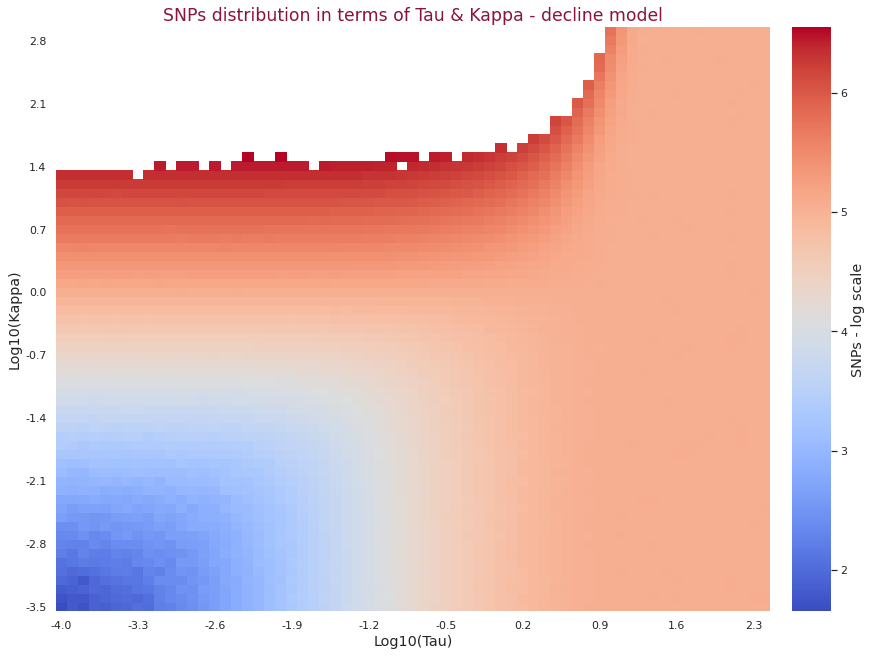

In [2]:
filin, path_data = "SFS_decline-default","./Data/Msprime/snp_distribution/decline/"
plot.plot_snp_distribution(model="decline", filin=filin, path_data=path_data)

Il y a une grande disparité dans le nombre de SNPs en fonction de tau & kappa.

> About 100 000 SNPs for each observed SFS

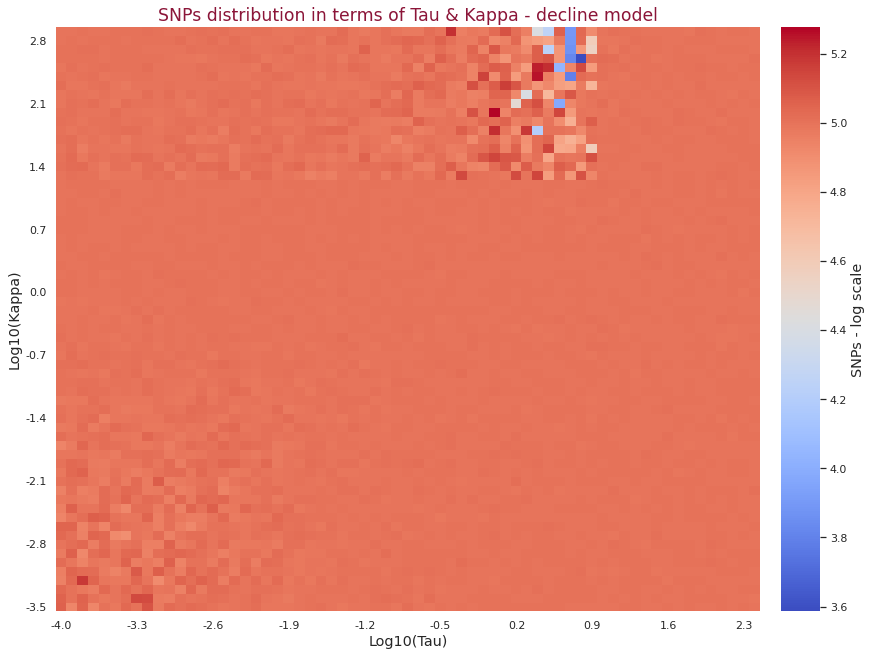

In [4]:
filin, path_data = "SFS_decline-fixed","./Data/Msprime/snp_distribution/decline/"
plot.plot_snp_distribution(model="decline", filin=filin, path_data=path_data)

<br>

### SNPs distribution - decline model

> By default

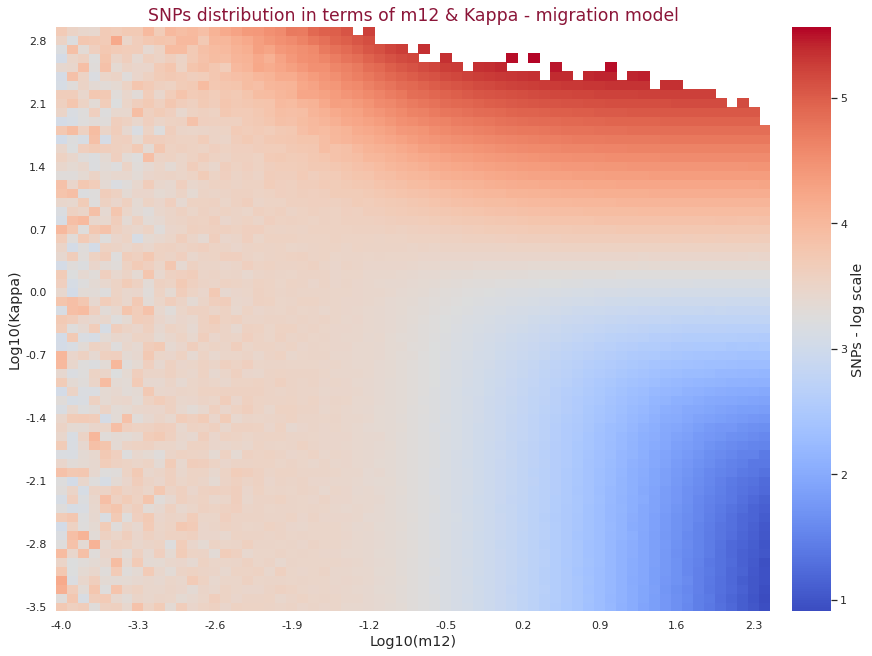

In [5]:
filin, path_data = "SFS_migration-default","./Data/Msprime/snp_distribution/migration/"
plot.plot_snp_distribution(model="migration", filin=filin, path_data=path_data)

Il y a une grande disparité dans le nombre de SNPs en fonction de m12 & kappa.

> About 100 000 SNPs for each observed SFS

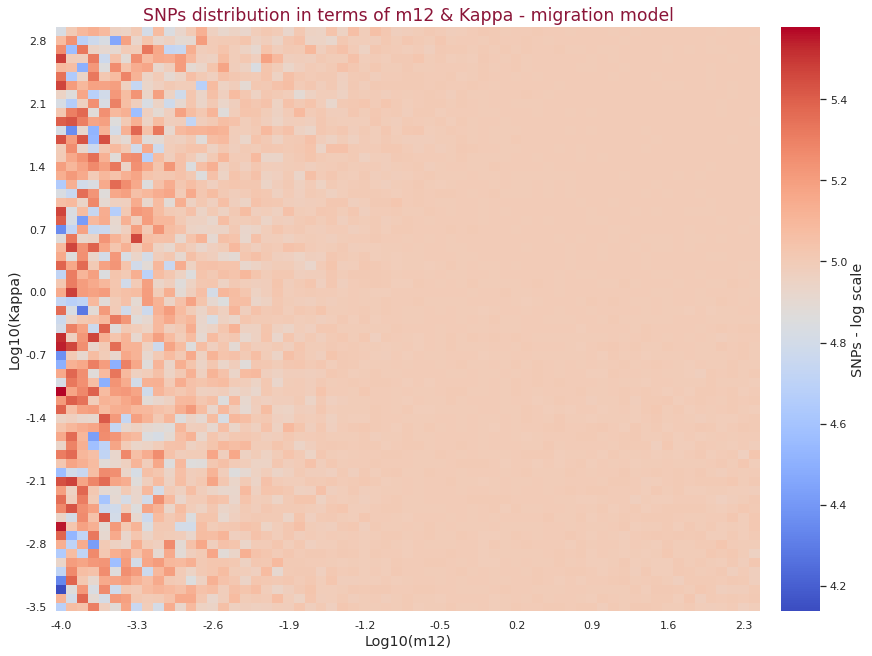

In [6]:
filin, path_data = "SFS_migration-fixed","./Data/Msprime/snp_distribution/migration/"
plot.plot_snp_distribution(model="migration", filin=filin, path_data=path_data)

<br>

<div style="font-size: 32px; font-style: bold;">Dadi inference</div>

Benchmark of dadi inference by weighted square distance & log-likelihood ratio test

<div style="color: #8b1538; font-size: 28px">1. Weighted square distance</div><br>

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$ [1]

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<br>

<div style="color: #8b1538; font-size: 15px;">[1] Each SFS must be normalized for comparison</div>

> Compute weighted square distance between theoritical SFS of any constant population & observed SFS (msprime)

In [53]:
def compute_theoritical_sfs(length):
    """
    compute the theoritical sfs of any constant population.
    """
    theoritical_sfs = [0] * (length)
    for i in range(length):
        theoritical_sfs[i] = 1 / (i+1)
    return theoritical_sfs


def normalization(sfs):
    """
    Normalization to (0;1)
    """
    return [ele / sum(sfs) for ele in sfs]


def compute_weighted_square_distance(data):
    theoritical_sfs = normalization(compute_theoritical_sfs(19))
    d2 = {}
    
    for i, row in data.iterrows():
        d2[i] = []
        for sfs in row['SFS observed']:
            for eta_obs, eta_theo in zip(normalization(sfs), theoritical_sfs):
                d2[i].append(np.power(eta_obs - eta_theo, 2) / eta_theo)
           
        d2[i] = np.mean(d2[i])
    
    return d2

<br>

<div style="color: #8b1538; font-size: 32px">2. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

<br>

<div style="color: #8b1538; font-size: 28px;">Vérification des paramètres estimés par Dadi</div>

Check infered parameters by Dadi.

In [52]:
def compute_parameters_evaluation(data, key):
    observed_params, estimated_params = [], []
    
    for _, row in data.iterrows():
        observed_params.append(np.log10(row['Parameters'][key]))
        estimated_params.append(np.log10(row['M1']['Estimated'][0][key]))

    return observed_params, estimated_params


def plot_parameters_evaluation(data, key, fixed):
    # Set up plot
    plt.figure(figsize=(10, 7))
    
    # Data
    observed_params, estimated_params = compute_parameters_evaluation(data, key)
    
    # Plot
    with plt.style.context('seaborn-whitegrid'):  # use seaborn style for plot
        plt.plot(observed_params, estimated_params, marker='.', linestyle="")
        plt.plot(observed_params, observed_params)
        
    # Label
    plt.xlabel("{} observés".format(key), fontsize="x-large")
    plt.ylabel("{} estimés".format(key), fontsize="x-large")
    
    # Title
    title = "{} observés en fonction de {} estimés pour log({}) = {}".format(key, key[0].lower() + key[1:], fixed[0], fixed[1])
    plt.title(title, fontsize="xx-large")
    
    # Plot vertical line for log(kappa) = 0
    if key == 'Kappa':
        plt.axvline(0, color="#8b1538")
    
    plt.plot()

> Compute distance

In [3]:
def compute_distance(data):
    # Compute distance between observed & estimated (Tau, kappa)
    estimated = {}
    for i, row in data.iterrows():
        estimated[i] = {}
    
        for key, observed in row['Parameters'].items():
            tmp = [np.power(observed - estimated[key], 2) / observed for estimated in row['M1']['Estimated']]
            estimated[i][key] = np.mean(tmp)

    # Creat pandas Data-Frame
    df = pd.DataFrame()
    for key in data['Parameters'][0].keys():
        df["{} observed".format(key)] = data['Parameters'].apply(lambda param: param[key])
        df["{} distance".format(key)] = pd.Series(estimated).apply(lambda param: param[key])
        
    return df

> Heatmap

In [16]:
def plot_distance_heatmap(data, key):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Pre-processing data
    df = pd.DataFrame()
    df = data.pivot(index="Kappa observed", columns="Tau observed", values=key)

    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar="{} - log sccale".format(key))
    
    # Title
    title = "Distance between observed & estimated {} for various (Tau, kappa)".format(key.split(' ')[0])
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

> Fixed tau or kappa

In [17]:
def plot_distance(data):
    key = ['Tau', 'Kappa']
    title = [
        'Distance between tau observed & estimated', 
        'Distance between kappa observed & estimated'
    ]
    
    # Set-up plot
    sns.set_theme(style='whitegrid')
    
    # Sub-plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Figsize: (width, height)
    
    # Plot
    for i, ax in enumerate(axs):  # Iterate through subplot
        
        # Plot
        _ = sns.lineplot(x="{} observed".format(key[i]), y="{} distance".format(key[i]), data=data, ax=ax, marker='o', err_style='bars')

        ax.set_title(title[i], fontsize="large")
        
    plt.suptitle("Distance between observed & estimated parameters", fontsize="x-large")
    
    plt.plot()

<br>

# Heatmap - sudden decline & growth model 

> Load data

In [3]:
data_all = f.export_inference_files('decline', 'all')

<br>

> Weighted square distance - observed SFS and inferred models

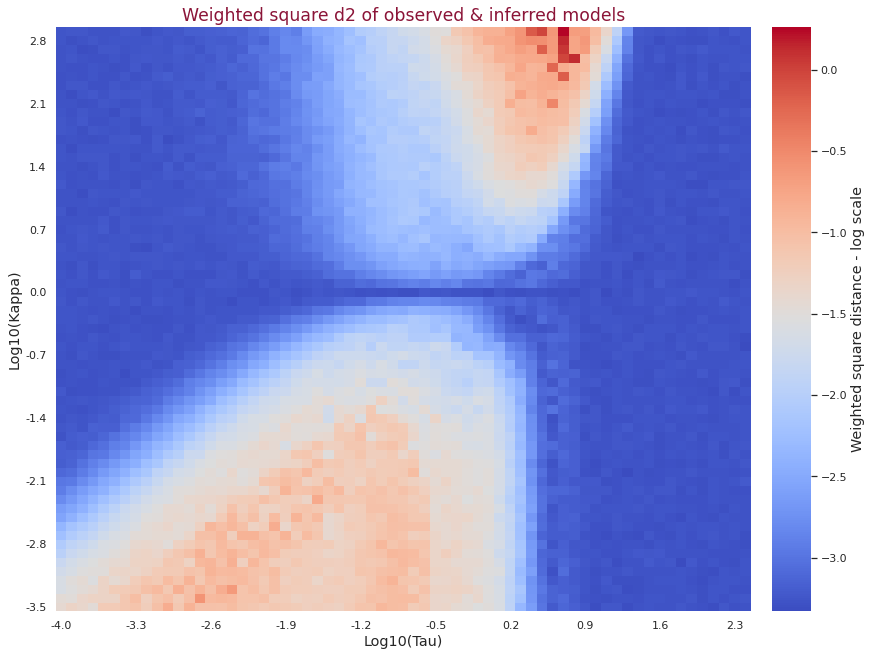

In [4]:
plot.plot_weighted_square_distance_heatmap(data=data_all, d2='d2 observed inferred', models=['observed', 'inferred'])

> Weighted square distance - observed SFS and theoritical SFS of any constant population

In [7]:
data_all['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(data_all))

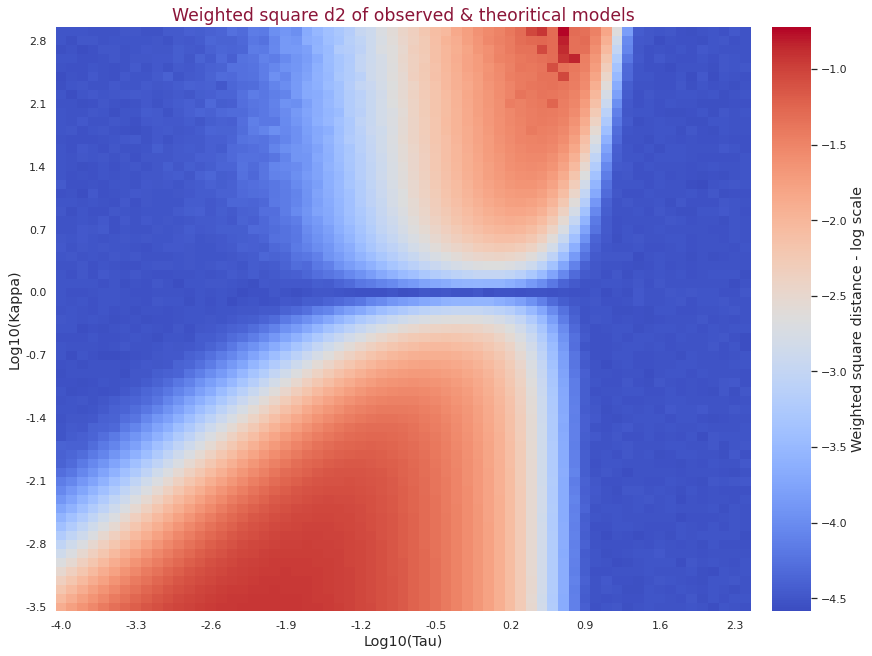

In [8]:
plot.plot_weighted_square_distance_heatmap(data=data_all, d2='d2 observed theoritical', models=['observed', 'theoretical'])

<br>

> Weighted square distance - M0 & M1

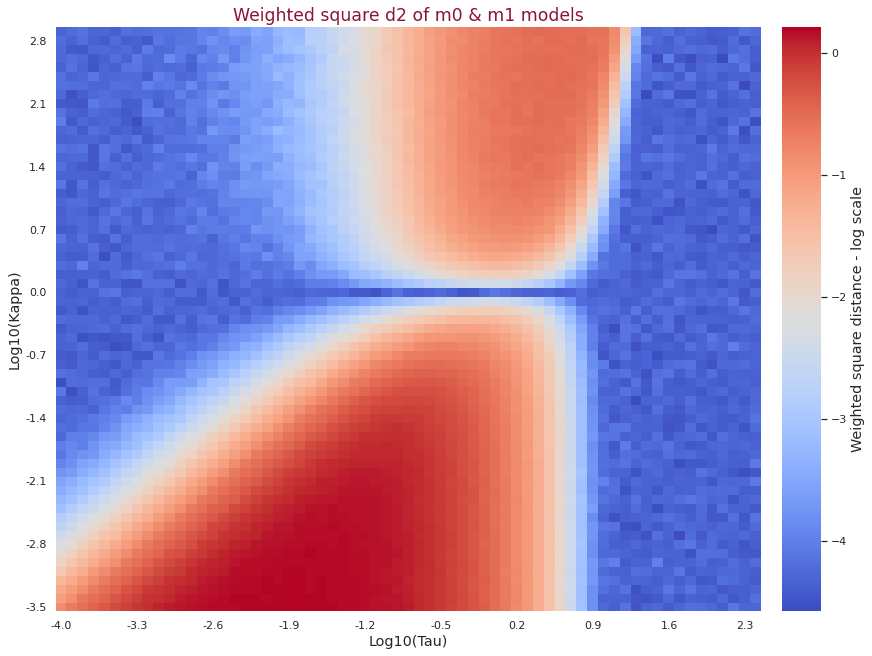

In [9]:
plot.plot_weighted_square_distance_heatmap(data=data_all, d2='d2 models', models=['m0', 'm1'])

<br>

> Log-likelihood ratio test

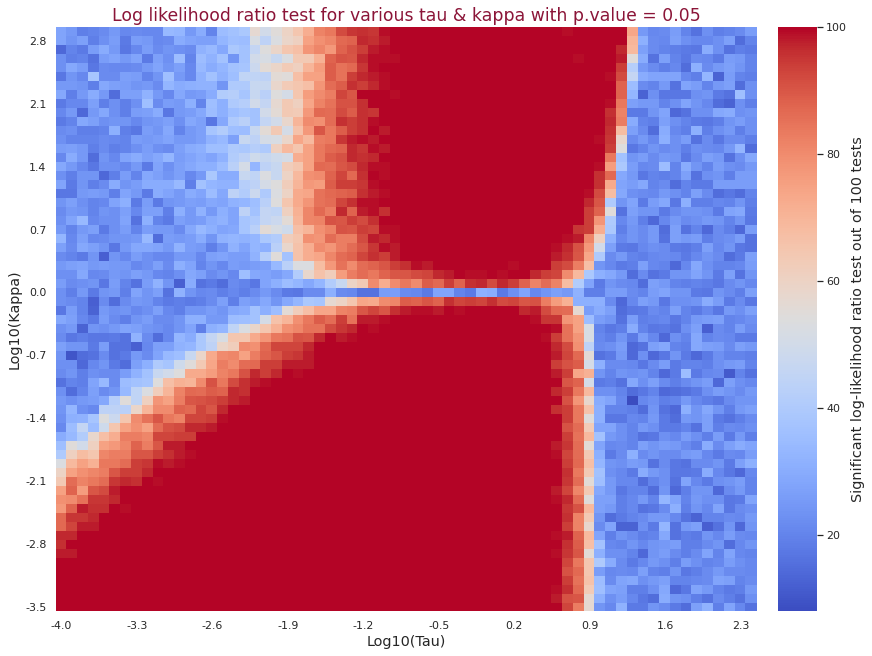

In [10]:
plot.plot_likelihood_heatmap(data_all)

> SFS shape

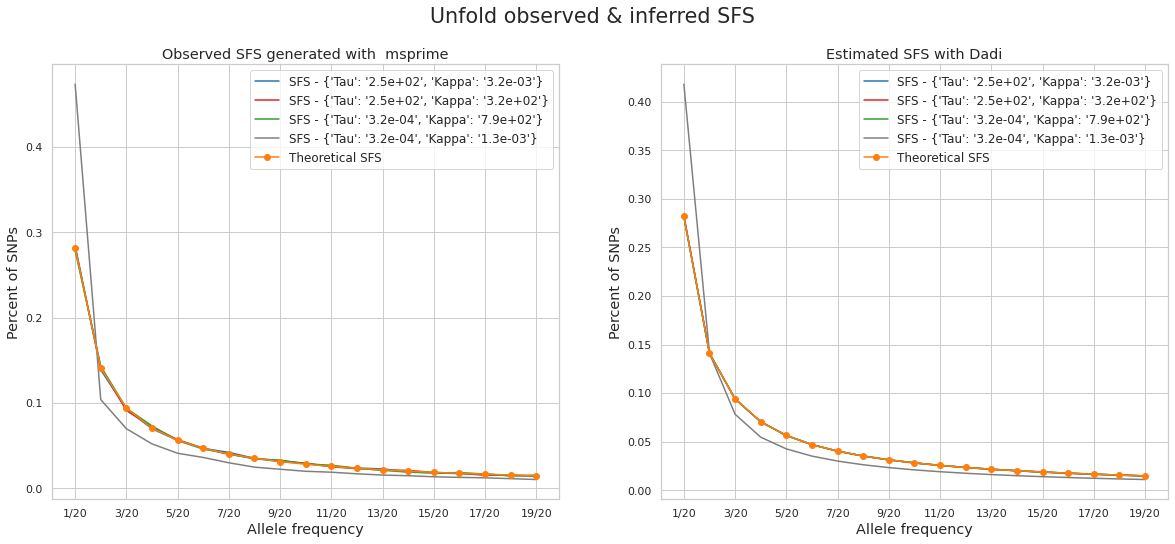

<Figure size 432x288 with 0 Axes>

In [11]:
plot.plot_sfs_inference(
    data=data_all, 
    parameters=[{'Tau': -3.5, 'Kappa': -2.9}, {'Tau': -3.5, 'Kappa': 2.9}, {'Tau': 2.4, 'Kappa': -2.5}, {'Tau': 2.4, 'Kappa': 2.5}], 
    colors=['tab:blue', 'tab:red', 'tab:green', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS"
)

<br>

> Vérification paramètre Dadi

In [22]:
distance = compute_distance(data_all)

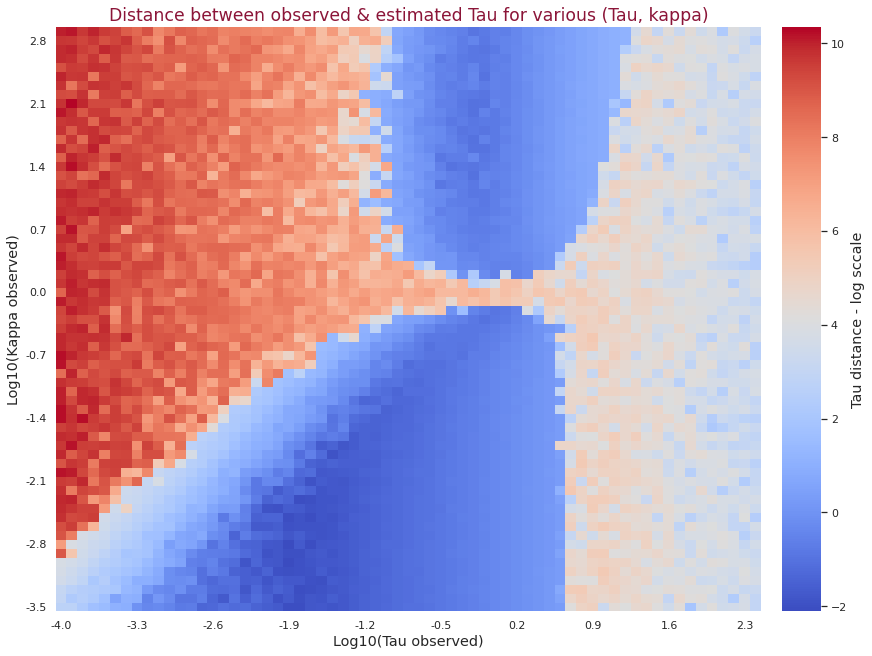

In [24]:
plot_inference_dadi_heatmap(distance, 'Tau distance')

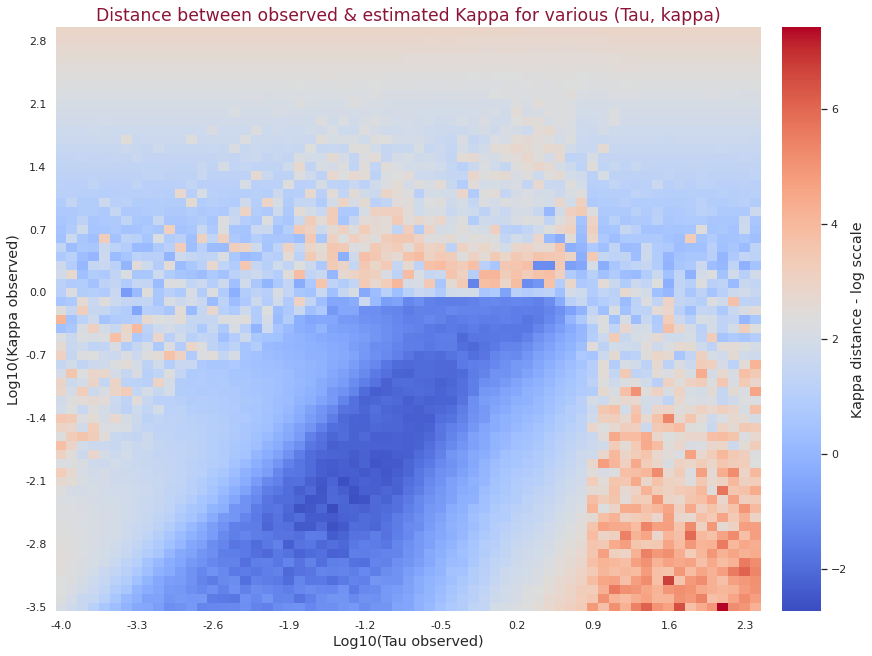

In [25]:
plot_inference_dadi_heatmap(distance, 'Kappa distance')

<br>

# Fixed kappa - sudden decline & growth model 

## Kappa -3.5, 0. & 2.5 in log sacle, i.e. 3.2e-4, 1.0 & 3.2e2

> Load data

In [30]:
data_kappa, labels_kappa = f.export_specific_dadi_inference(model='decline', fixed_param='kappa', values=[-2.5, 0., 2.5])

> Weighted square distance

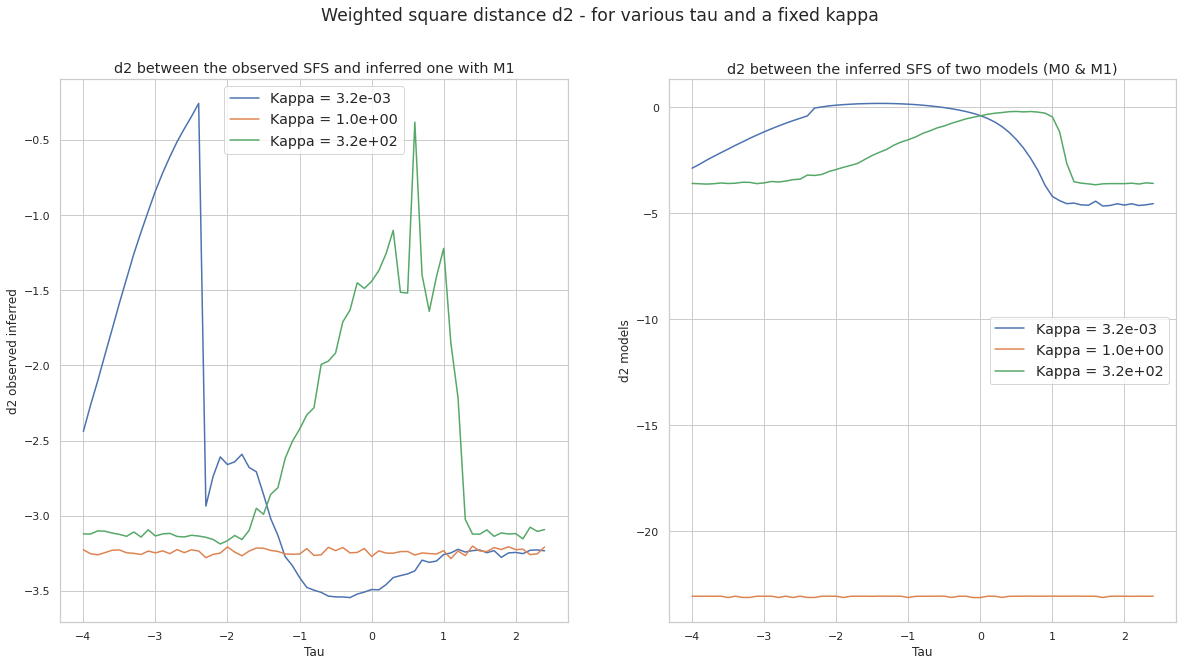

In [31]:
plot.plot_weighted_square_distance(
    data=data_kappa, fixed="Tau", labels=labels_kappa,
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa"
)

> Weighted square distance - observed SFS and theoritical SFS of any constant population

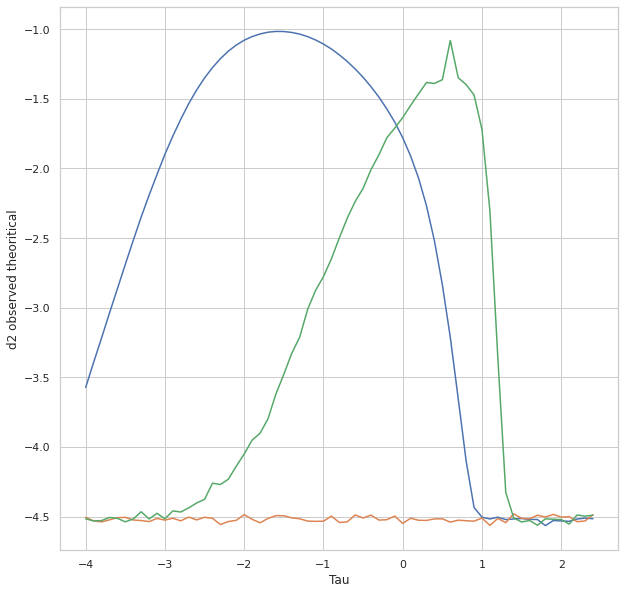

In [25]:
plt.figure(figsize=(10,10))
sns.set_theme(style='whitegrid')

for dataframe in data_kappa:
    # Data
    df = pd.DataFrame()
    df['Tau'] = dataframe['Parameters'].apply(lambda param: np.log10(param['Tau']))
    df['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(dataframe)).apply(np.log10)
    
    # Plot
    _ = sns.lineplot(x="Tau", y="d2 observed theoritical", data=df)

> SFS shape

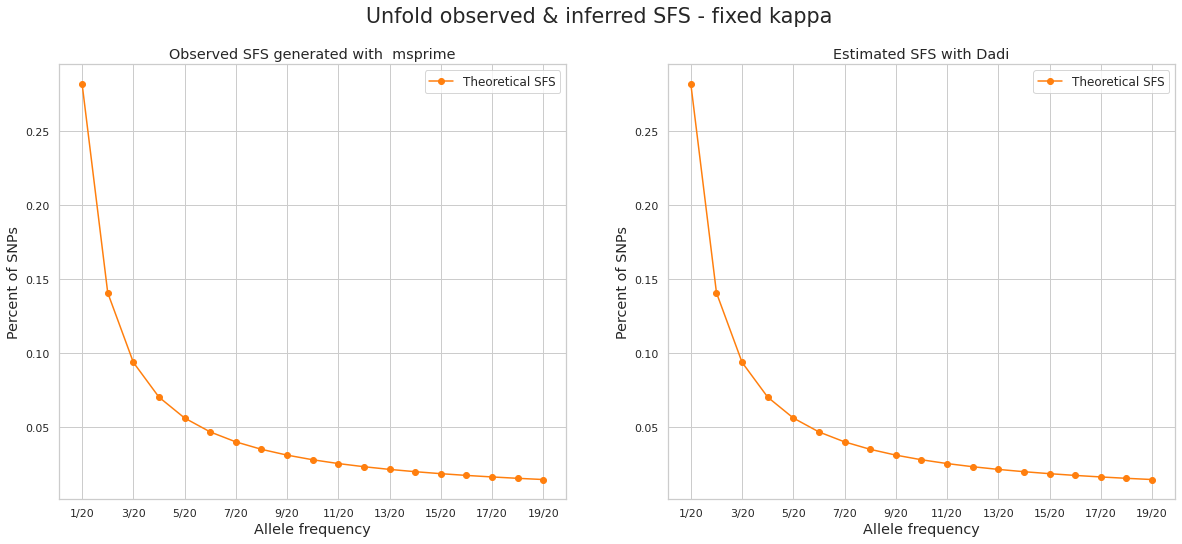

<Figure size 432x288 with 0 Axes>

In [26]:
plot.plot_sfs_inference(
    data=data_kappa[0], 
    parameters=[{'Tau': -3.5, 'Kappa': -3.5}, {'Tau': -3, 'Kappa': -3.5}, {'Tau': -2.5, 'Kappa': -3.5}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed kappa"
)

> Log-likelihood ratio test

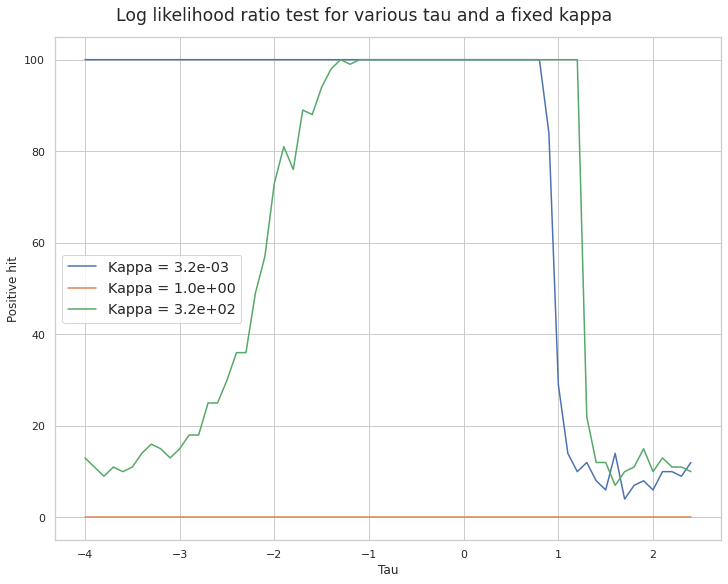

In [32]:
plot.plot_likelihood(
    data=data_kappa, fixed="Tau", labels=labels_kappa,
    suptitle="Log likelihood ratio test for various tau and a fixed kappa"
)

> Evaluation paramètres estimés

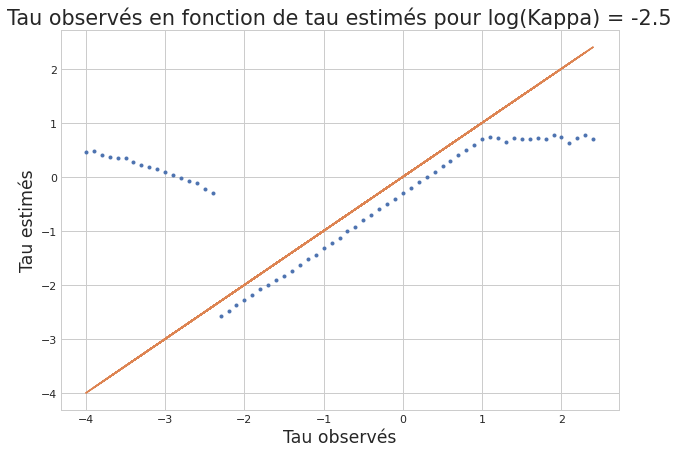

In [34]:
plot_parameters_evaluation(data=data_kappa[0], key="Tau", fixed=('Kappa', -2.5))

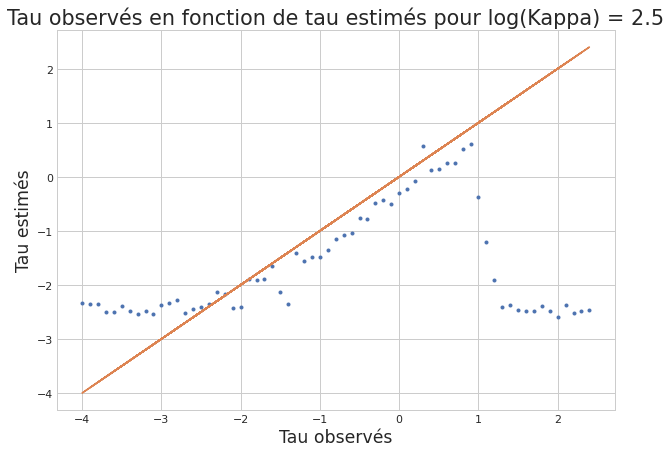

In [35]:
plot_parameters_evaluation(data=data_kappa[2], key="Tau", fixed=('Kappa', 2.5))

<br>

## Kappa 0.3 & 1 in log scale, i.e. 2 & 10

> Load data

In [36]:
data_kappa2, labels_kappa2 = f.export_specific_dadi_inference(model='decline', fixed_param='kappa', values=[0.3, 1.])

> Weighted square distance

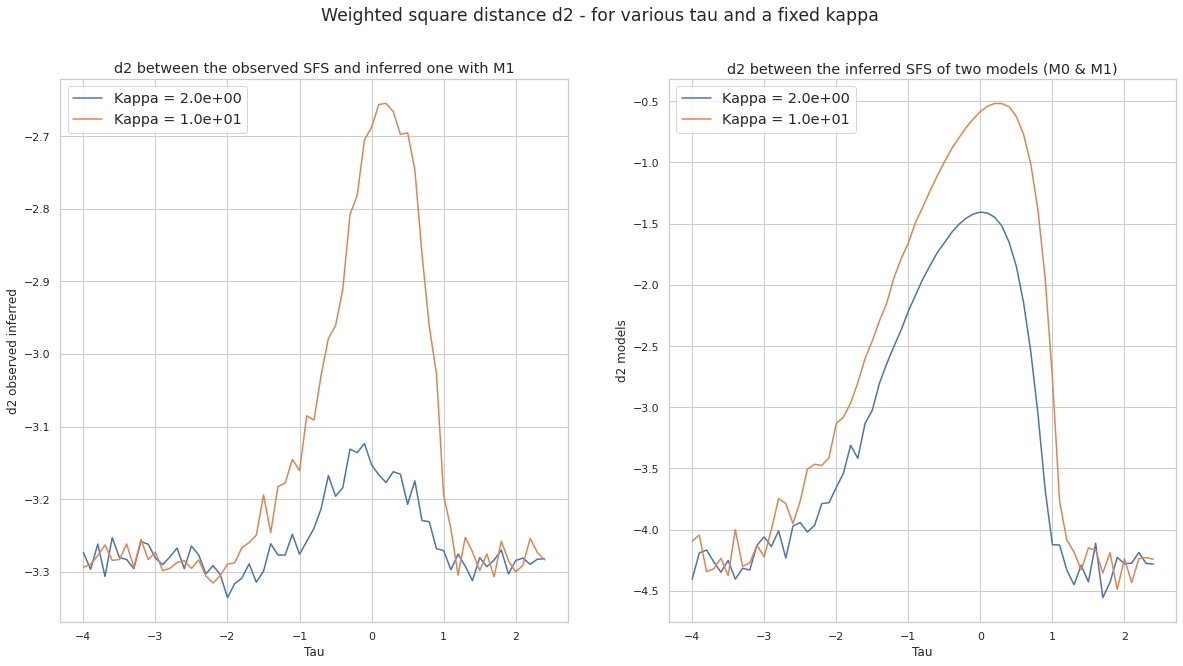

In [38]:
plot.plot_weighted_square_distance(
    data=data_kappa2, fixed="Tau", labels=labels_kappa2,
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa"
)

> Log-likelihood ratio test

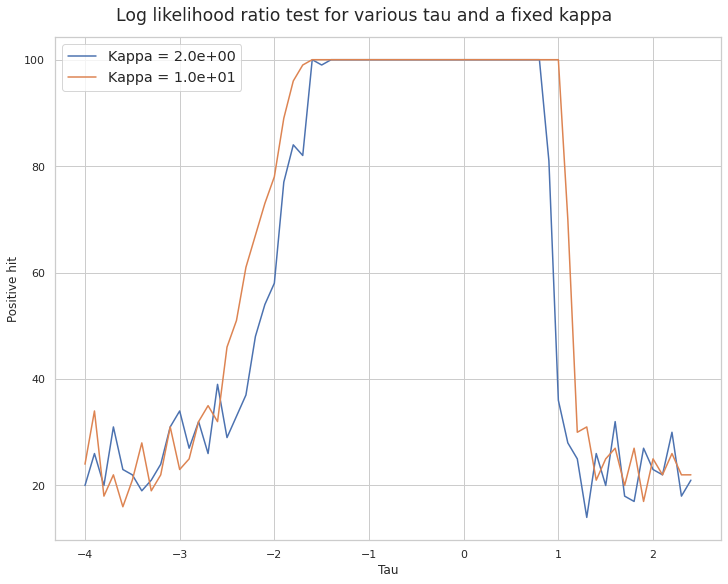

In [39]:
plot.plot_likelihood(
    data=data_kappa2, fixed="Tau", labels=labels_kappa2,
    suptitle="Log likelihood ratio test for various tau and a fixed kappa"
)

> SFS shape

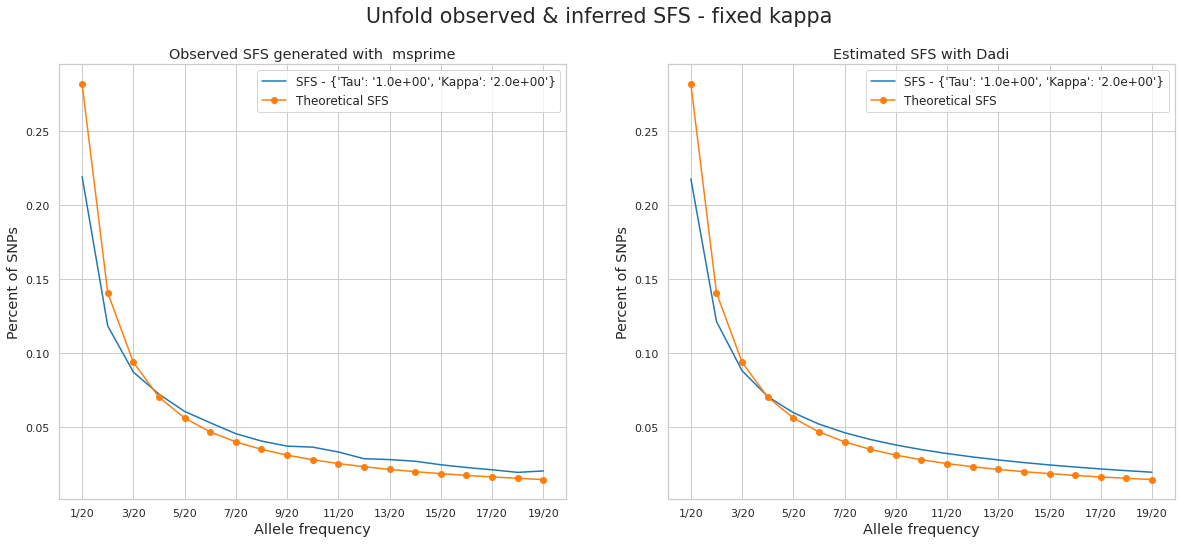

<Figure size 432x288 with 0 Axes>

In [40]:
plot.plot_sfs_inference(
    data=data_kappa2[0], 
    parameters=[{'Tau': 0., 'Kappa': 0.3}, {'Tau': 0., 'Kappa': 1}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed kappa"
)

> Evaluation paramètres estimés

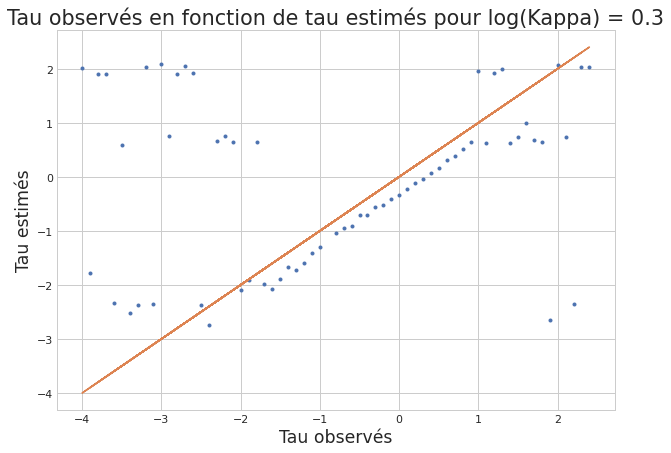

In [43]:
plot_parameters_evaluation(data=data_kappa2[0], key="Tau", fixed=('Kappa', 0.3))

<br>

## Fixed tau - sudden decline & growth model 

### Tau -2.4, 0. & 2.4, i.e. 4e-3, 1. & 251

> Load data

In [46]:
data_tau, labels_tau = f.export_specific_dadi_inference(model='decline', fixed_param='tau', values=[-2.4, 0., 2.4])

> Weighted square distance

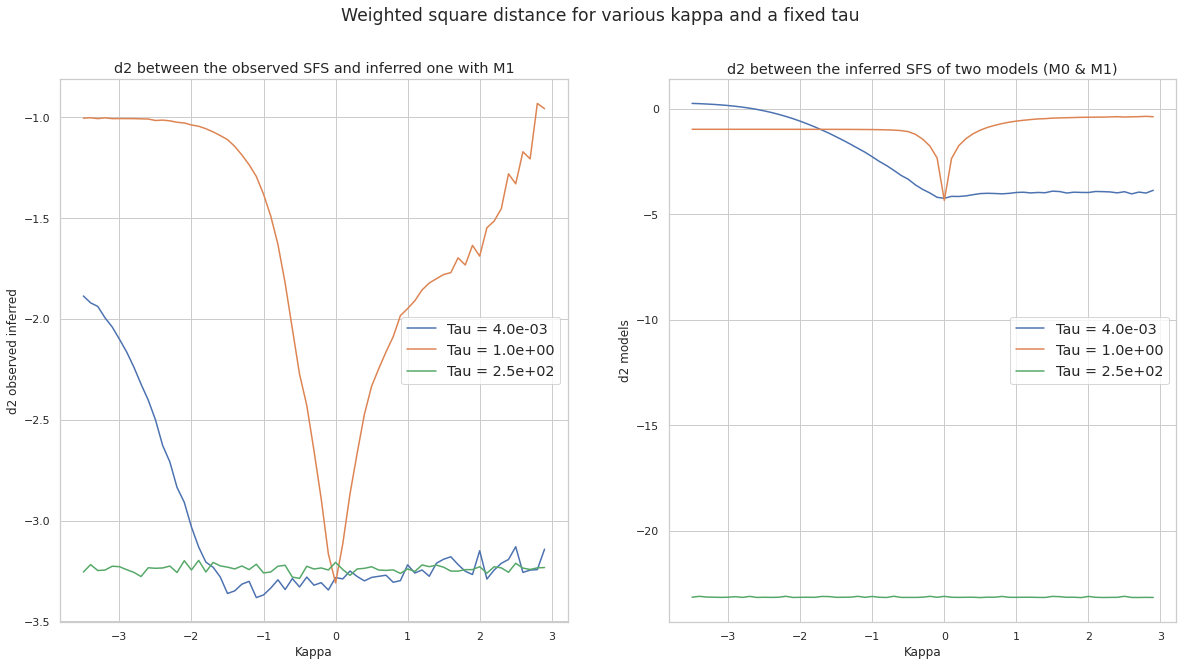

In [47]:
plot.plot_weighted_square_distance(
    data=data_tau, fixed="Kappa", labels=labels_tau,
    suptitle="Weighted square distance for various kappa and a fixed tau")

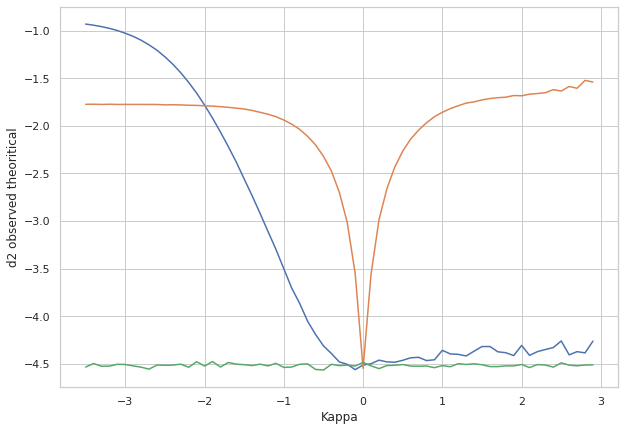

In [54]:
plt.figure(figsize=(10,7))
sns.set_theme(style='whitegrid')

for dataframe in data_tau:
    # Data
    df = pd.DataFrame()
    df['Kappa'] = dataframe['Parameters'].apply(lambda param: np.log10(param['Kappa']))
    df['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(dataframe)).apply(np.log10)
    
    # Plot
    _ = sns.lineplot(x="Kappa", y="d2 observed theoritical", data=df)

> Log-likelihood ratio test

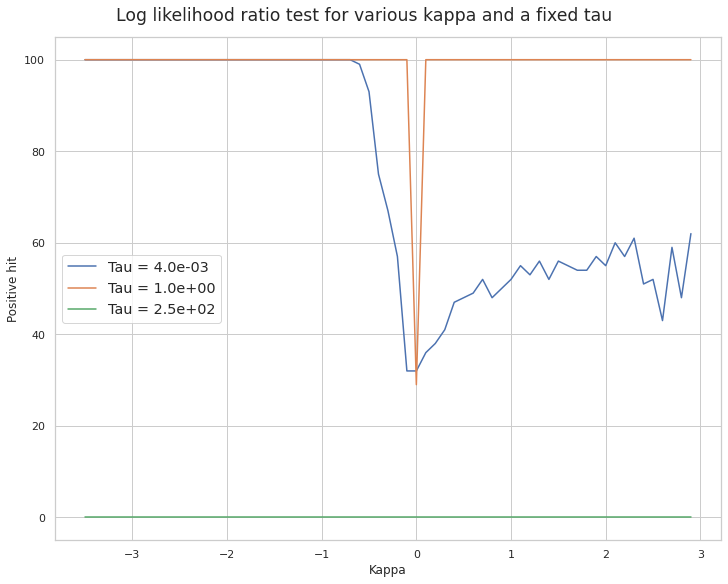

In [49]:
plot.plot_likelihood(
    data=data_tau, fixed="Kappa", labels=labels_tau,
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")

> SFS shape

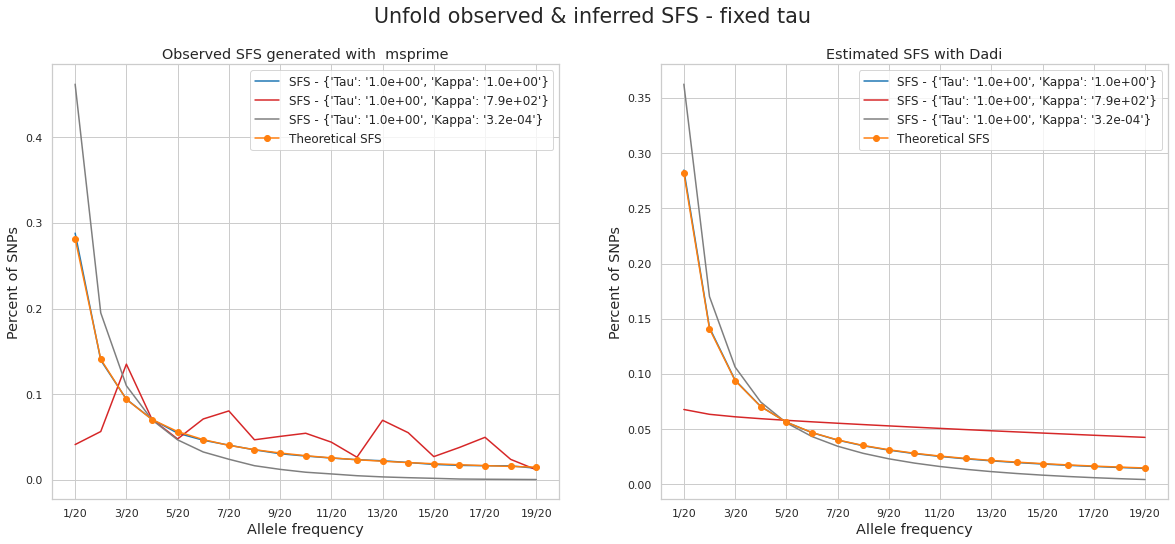

<Figure size 432x288 with 0 Axes>

In [55]:
plot.plot_sfs_inference(
    data=data_tau[1], 
    parameters=[{'Tau': 0., 'Kappa': -3.5}, {'Tau': 0., 'Kappa': 0}, {'Tau': 0., 'Kappa': 2.9}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed tau"
)

> Evaluation paramètres estimés

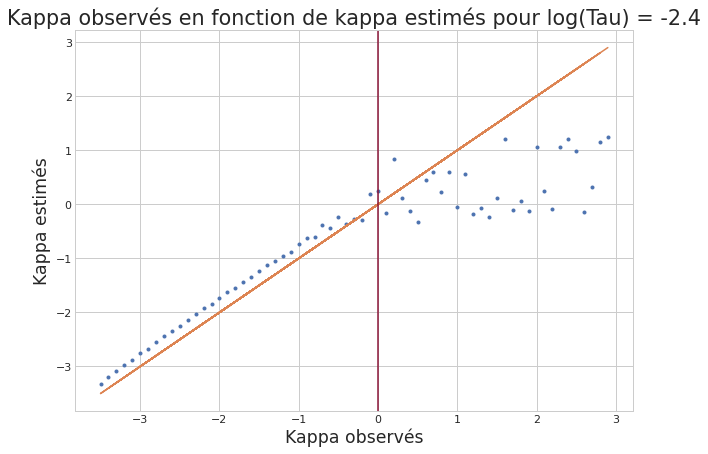

In [60]:
plot_parameters_evaluation(data=data_tau[0], key="Kappa", fixed=('Tau', -2.4))

<br>

# Stairway plot 2 inference

### Constan population

Stairway plot inference for some constant population with Ne = 1, Ne = 2, Ne = 10 & Ne = 100.

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

In [2]:
def sfs_cst_pop():
    # DataFrame
    data = pd.DataFrame(columns=['Parameters', 'SNPs', 'SFS observed'])
    
    # Parameters for the simulation
    params = {"sample_size": 20, "Ne": 0, "rcb_rate": 2e-2, "mu": 2e-2, "length": 1e5}
    
    for ne in [1, 2, 10]:
        params['Ne'] = ne
        
        # Constant scenario
        sfs = ms.msprime_simulation(model=ms.constant_model, params=params, debug=True)
        
        dico = {'Parameters': params.copy(), 'SNPs': [np.mean(sfs)], 'SFS observed': [sfs]}
        data = data.append(dico, ignore_index=True)
        
    return data


def inference_cst_pop(generate=False):
    if generate:
        data = sfs_cst_pop()
        data.to_json("./Data/Msprime/cst/SFS-cst")
    else:
        data = pd.read_json("./Data/Msprime/cst/SFS-cst")
        
    return data

In [3]:
simulation = inference_cst_pop(generate=False)

In [4]:
simulation

,Parameters,SNPs,SFS observed
0,"{'sample_size': 20, 'Ne': 1, 'rcb_rate': 0.02,...",[1462.1578947368],"[[7471, 4056, 2625, 1957, 1514, 1294, 1165, 10..."
1,"{'sample_size': 20, 'Ne': 2, 'rcb_rate': 0.02,...",[2986.1052631579],"[[15996, 8189, 5265, 4084, 3094, 2723, 2093, 2..."
2,"{'sample_size': 20, 'Ne': 10, 'rcb_rate': 0.02...",[15017.8421052632],"[[80377, 40178, 26825, 20229, 16309, 13161, 11..."


In [5]:
%%capture

for _, row in simulation.iterrows():
    sei.save_stairway_inference(row, 'cst')
    break

<br>

In [6]:
data = pd.read_json("./Data/Msprime/decline/SFS_decline-all")

Text(0.5, 1.0, "{'Tau': 0.0006309573, 'Kappa': 794.3282347243}")

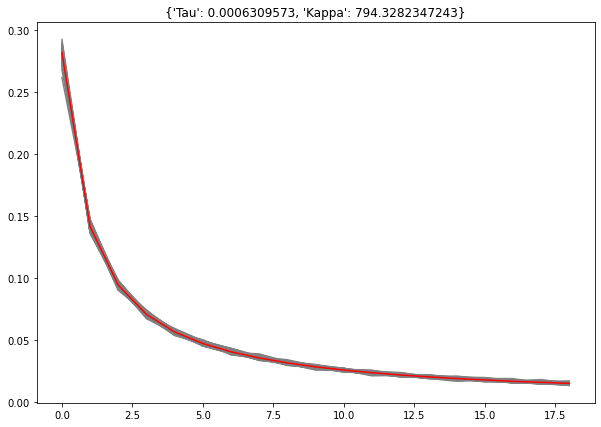

In [75]:
sfs = data.iloc[0]['SFS observed']
new = np.array([sum(spectrum) for spectrum in zip(*sfs)]) / len(sfs)

plt.figure(figsize=(10, 7))

for spectrum in sfs:
    plt.plot([ele/sum(spectrum) for ele in spectrum], color="grey")
plt.plot([ele/sum(new) for ele in new], color="red")
plt.title({k: v for k, v in data.iloc[0]['Parameters'].items() if k in ['Tau', 'Kappa']})

<br>

# Update size_population to Ne

In [9]:
filin, path_data = "SFS_migration-default","./Data/Msprime/snp_distribution/migration/"
data_all = load_data(filin, path_data)

In [10]:
data_all.columns

Index(['Parameters', 'SNPs', 'SFS observed', 'Time'], dtype='object')

In [12]:
data_all.iloc[0]

Parameters      {'m12': 3.9810717055, 'm21': 0.0, 'Kappa': 251...
SNPs            [257847, 257181, 244535, 257531, 248578, 25085...
SFS observed    [[60538, 34784, 24691, 20059, 15848, 13249, 11...
Time                                                      197.821
Name: 0, dtype: object

In [56]:
data_all['Parameters'] = data_all['Parameters'].apply(lambda param: {('Ne' if k == 'size_population' else k): v for k, v in param.items()})

In [57]:
data_all.to_json('{}{}'.format(path_data, filin))